# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

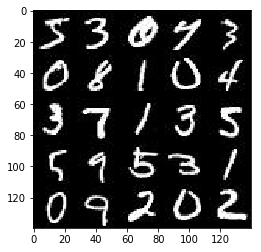

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

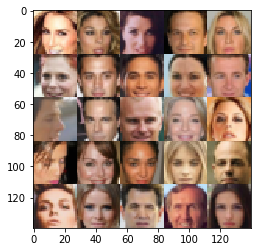

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels],
                                 name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [71]:
def lrelu(x, alpha):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    keep_prob = 0.5
    xav_init = tf.contrib.layers.xavier_initializer()
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 32, 4, strides=2, padding='same', kernel_initializer=xav_init)
        x1 = tf.layers.dropout(x1, rate=keep_prob, training=True)
        relu1 = lrelu(x1, alpha)
        # 7x7x64
        
        x2 = tf.layers.conv2d(relu1, 64, 4, strides=2, padding='same', kernel_initializer=xav_init)
        x2 = tf.layers.dropout(x2, rate=keep_prob, training=True)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2, alpha)
        # 4x4x128
        
        x3 = tf.layers.conv2d(relu2, 128, 4, strides=2, padding='same', kernel_initializer=xav_init)
        x3 = tf.layers.dropout(x3, rate=keep_prob, training=True)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3, alpha)
        
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    keep_prob = 0.5
    xav_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1, alpha)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid', kernel_initializer=xav_init)
        x2 = tf.layers.dropout(x2, rate=keep_prob, training=is_train)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2, alpha)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=xav_init)
        x3 = tf.layers.dropout(x3, rate=keep_prob, training=is_train)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3, alpha)
        # 28x28x64 now
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=xav_init)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    smooth = 0.1
    
    d_loss_real_labels = tf.ones_like(d_model_real) * (1 - smooth)
    d_loss_fake_labels = tf.zeros_like(d_model_fake)
    g_loss_labels = tf.ones_like(d_model_fake)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_loss_real_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_loss_fake_labels))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_loss_labels))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [76]:
class GAN:
    def __init__(self, real_size, z_size, alpha=0.2, beta1=0.5):
        w, h, c = real_size
        
        self.input_real, self.input_z, self.lr = model_inputs(w, h, c, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              c, alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.lr, beta1)

In [77]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 100
    
    num_channels = data_shape[3]
    
    net = GAN(data_shape[1:], z_dim, beta1=beta1)
    saver = tf.train.Saver()

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for x in get_batches(batch_size):
                steps += 1
                x *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z, net.lr: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x, net.lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 16, net.input_z, num_channels, data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 1.5732... Generator Loss: 1.1375
Epoch 1/4... Discriminator Loss: 0.9656... Generator Loss: 1.5269
Epoch 1/4... Discriminator Loss: 1.2682... Generator Loss: 1.1377
Epoch 1/4... Discriminator Loss: 1.0790... Generator Loss: 1.2542


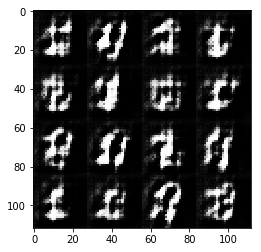

Epoch 1/4... Discriminator Loss: 1.0356... Generator Loss: 1.1748
Epoch 1/4... Discriminator Loss: 1.2422... Generator Loss: 0.8786
Epoch 1/4... Discriminator Loss: 1.1253... Generator Loss: 0.8033
Epoch 1/4... Discriminator Loss: 1.2143... Generator Loss: 1.7961


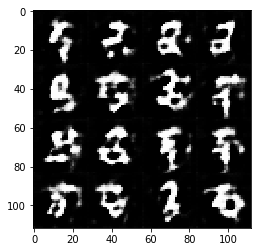

Epoch 1/4... Discriminator Loss: 1.1988... Generator Loss: 0.9743
Epoch 1/4... Discriminator Loss: 1.2413... Generator Loss: 0.7690
Epoch 1/4... Discriminator Loss: 1.4028... Generator Loss: 1.4147
Epoch 1/4... Discriminator Loss: 1.0624... Generator Loss: 1.1182


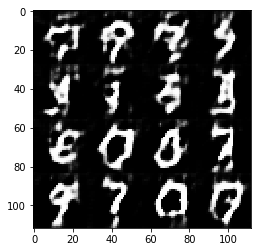

Epoch 1/4... Discriminator Loss: 1.0980... Generator Loss: 0.9850
Epoch 1/4... Discriminator Loss: 1.3063... Generator Loss: 1.6301
Epoch 1/4... Discriminator Loss: 0.9773... Generator Loss: 1.3314
Epoch 1/4... Discriminator Loss: 1.3888... Generator Loss: 1.0378


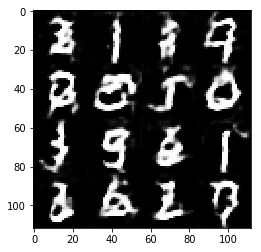

Epoch 1/4... Discriminator Loss: 0.9906... Generator Loss: 1.0682
Epoch 1/4... Discriminator Loss: 0.9061... Generator Loss: 1.0607
Epoch 2/4... Discriminator Loss: 1.3097... Generator Loss: 0.8948
Epoch 2/4... Discriminator Loss: 1.0817... Generator Loss: 1.3094


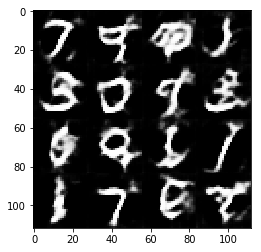

Epoch 2/4... Discriminator Loss: 1.1237... Generator Loss: 1.0616
Epoch 2/4... Discriminator Loss: 1.0209... Generator Loss: 0.7304
Epoch 2/4... Discriminator Loss: 1.1622... Generator Loss: 1.2598
Epoch 2/4... Discriminator Loss: 1.1307... Generator Loss: 1.1867


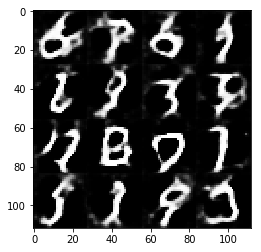

Epoch 2/4... Discriminator Loss: 1.2844... Generator Loss: 1.3251
Epoch 2/4... Discriminator Loss: 1.1615... Generator Loss: 1.1299
Epoch 2/4... Discriminator Loss: 1.3753... Generator Loss: 1.0427
Epoch 2/4... Discriminator Loss: 1.0795... Generator Loss: 0.9942


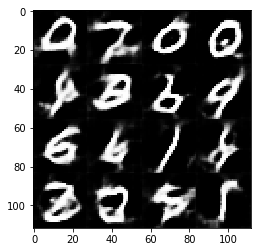

Epoch 2/4... Discriminator Loss: 1.3725... Generator Loss: 0.7674
Epoch 2/4... Discriminator Loss: 1.5410... Generator Loss: 0.9642
Epoch 2/4... Discriminator Loss: 1.0921... Generator Loss: 1.2785
Epoch 2/4... Discriminator Loss: 1.2257... Generator Loss: 1.5161


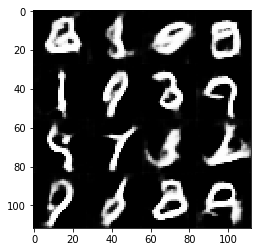

Epoch 2/4... Discriminator Loss: 1.2026... Generator Loss: 1.2992
Epoch 2/4... Discriminator Loss: 1.2197... Generator Loss: 0.8132
Epoch 2/4... Discriminator Loss: 1.4356... Generator Loss: 0.7673
Epoch 2/4... Discriminator Loss: 1.4266... Generator Loss: 1.1133


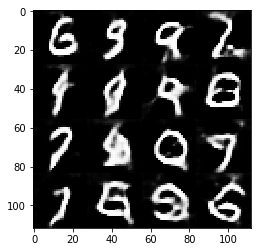

Epoch 2/4... Discriminator Loss: 1.2807... Generator Loss: 1.1154
Epoch 3/4... Discriminator Loss: 1.4658... Generator Loss: 1.4630
Epoch 3/4... Discriminator Loss: 0.9165... Generator Loss: 1.2262
Epoch 3/4... Discriminator Loss: 1.2417... Generator Loss: 1.0236


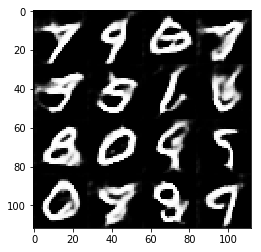

Epoch 3/4... Discriminator Loss: 0.9952... Generator Loss: 1.4809
Epoch 3/4... Discriminator Loss: 0.9440... Generator Loss: 1.5804
Epoch 3/4... Discriminator Loss: 1.1578... Generator Loss: 1.1748
Epoch 3/4... Discriminator Loss: 1.0173... Generator Loss: 1.4775


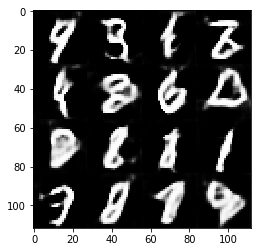

Epoch 3/4... Discriminator Loss: 1.3752... Generator Loss: 1.0026
Epoch 3/4... Discriminator Loss: 0.9553... Generator Loss: 1.8428
Epoch 3/4... Discriminator Loss: 1.2449... Generator Loss: 1.8422
Epoch 3/4... Discriminator Loss: 1.1233... Generator Loss: 1.3845


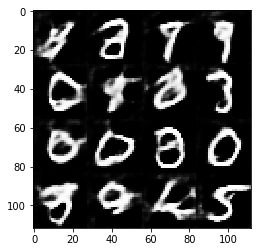

Epoch 3/4... Discriminator Loss: 0.7879... Generator Loss: 1.0896
Epoch 3/4... Discriminator Loss: 0.9050... Generator Loss: 1.4536
Epoch 3/4... Discriminator Loss: 0.7019... Generator Loss: 0.9909
Epoch 3/4... Discriminator Loss: 0.9129... Generator Loss: 1.0611


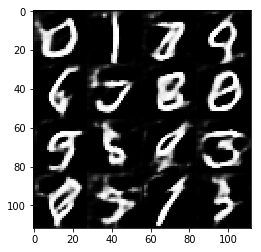

Epoch 3/4... Discriminator Loss: 1.0864... Generator Loss: 1.2942
Epoch 3/4... Discriminator Loss: 1.1657... Generator Loss: 1.1695
Epoch 3/4... Discriminator Loss: 0.8887... Generator Loss: 0.9055
Epoch 3/4... Discriminator Loss: 0.8133... Generator Loss: 1.2446


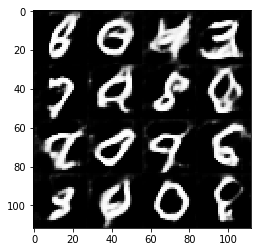

Epoch 4/4... Discriminator Loss: 1.6315... Generator Loss: 1.0815
Epoch 4/4... Discriminator Loss: 0.8296... Generator Loss: 1.1934
Epoch 4/4... Discriminator Loss: 0.8775... Generator Loss: 1.0785
Epoch 4/4... Discriminator Loss: 0.8356... Generator Loss: 1.5446


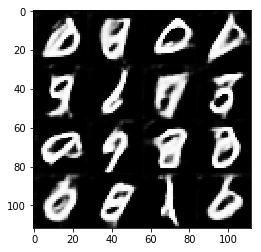

Epoch 4/4... Discriminator Loss: 1.1058... Generator Loss: 2.0306
Epoch 4/4... Discriminator Loss: 1.2769... Generator Loss: 2.6551
Epoch 4/4... Discriminator Loss: 0.6837... Generator Loss: 2.1934
Epoch 4/4... Discriminator Loss: 1.0810... Generator Loss: 1.8916


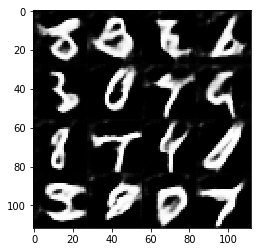

Epoch 4/4... Discriminator Loss: 1.0165... Generator Loss: 2.3848
Epoch 4/4... Discriminator Loss: 0.8753... Generator Loss: 2.3901
Epoch 4/4... Discriminator Loss: 0.6068... Generator Loss: 1.7293
Epoch 4/4... Discriminator Loss: 0.6314... Generator Loss: 1.6619


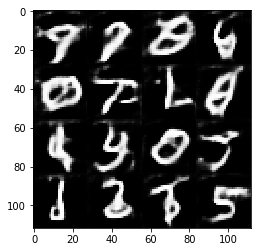

Epoch 4/4... Discriminator Loss: 1.3371... Generator Loss: 2.5173
Epoch 4/4... Discriminator Loss: 0.6558... Generator Loss: 2.7374
Epoch 4/4... Discriminator Loss: 0.5310... Generator Loss: 1.7375
Epoch 4/4... Discriminator Loss: 0.9183... Generator Loss: 1.2491


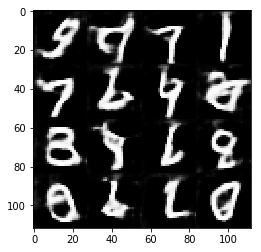

Epoch 4/4... Discriminator Loss: 0.8251... Generator Loss: 1.6789
Epoch 4/4... Discriminator Loss: 1.2926... Generator Loss: 2.3373
Epoch 4/4... Discriminator Loss: 0.7782... Generator Loss: 1.7363


In [80]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, show_every=400)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 2.0042
Epoch 1/2... Discriminator Loss: 0.6664... Generator Loss: 2.2953
Epoch 1/2... Discriminator Loss: 0.5991... Generator Loss: 2.8322
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 2.5643


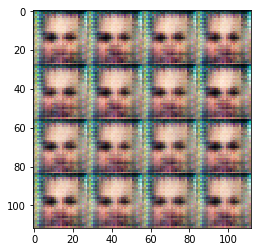

Epoch 1/2... Discriminator Loss: 0.7235... Generator Loss: 2.5763
Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 2.3164
Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.4798
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.8440


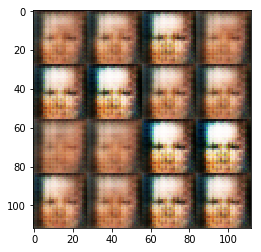

Epoch 1/2... Discriminator Loss: 0.7876... Generator Loss: 1.7384
Epoch 1/2... Discriminator Loss: 0.5136... Generator Loss: 2.7936
Epoch 1/2... Discriminator Loss: 0.6664... Generator Loss: 1.6927
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 2.2080


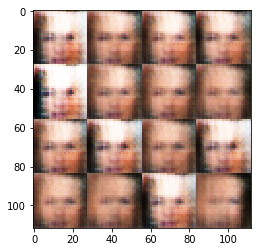

Epoch 1/2... Discriminator Loss: 0.7162... Generator Loss: 2.2932
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.6460
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.4649
Epoch 1/2... Discriminator Loss: 1.2649... Generator Loss: 1.5492


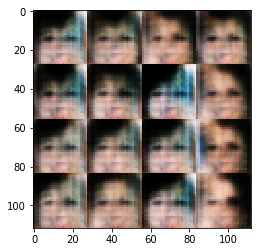

Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.2328
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 1.0867
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 1.5016


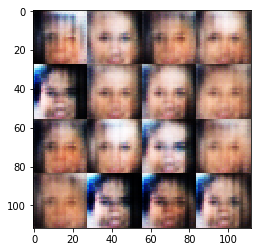

Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 1.2433
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 1.4393


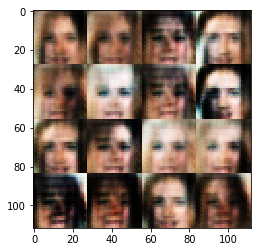

Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 1.1742
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 1.7048
Epoch 1/2... Discriminator Loss: 1.0999... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 1.4104


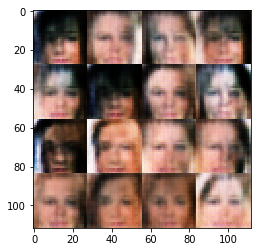

Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 1.2287
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 1.2577
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.9208


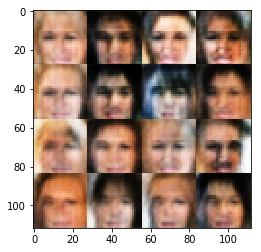

Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.0891
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 1.0150
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.2691


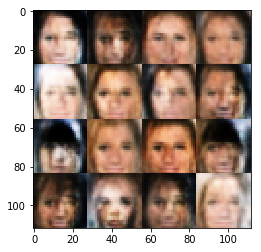

Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.9923
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.3946
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 1.1075
Epoch 2/2... Discriminator Loss: 1.2666... Generator Loss: 1.2157


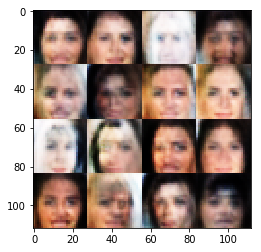

Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 1.3720
Epoch 2/2... Discriminator Loss: 1.2079... Generator Loss: 1.0708
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 1.3691
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 1.0496


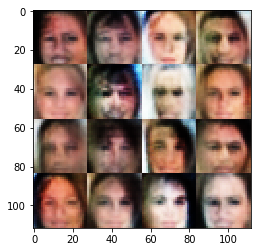

Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.8864
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.1934... Generator Loss: 1.0056
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 1.1304


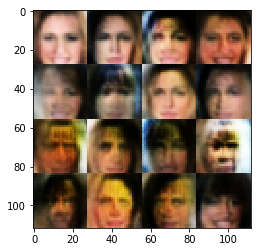

Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 1.4309
Epoch 2/2... Discriminator Loss: 1.2768... Generator Loss: 1.0705
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 1.1505
Epoch 2/2... Discriminator Loss: 1.1081... Generator Loss: 1.0544


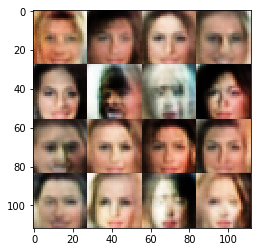

Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 1.1049
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 1.3331
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 1.0034
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 1.3685


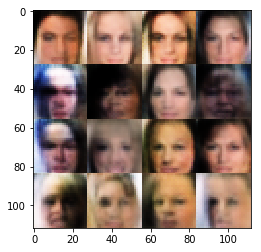

Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.9663
Epoch 2/2... Discriminator Loss: 1.0550... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.8055


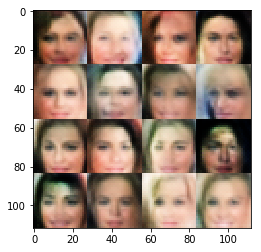

Epoch 2/2... Discriminator Loss: 1.1103... Generator Loss: 1.2917
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.8911


In [81]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, show_every=400)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.